In [2]:
from numba.cpython.slicing import slice_indices
%reload_ext autoreload
%autoreload 2

from lib.formatting import bitstring_to_int
from lib.data_loading import load_measurements, MixedDataLoader
from lib.state_io import load_state_vector

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence, Callable

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
from jax.random import PRNGKey
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn
from jaxtyping import PyTree

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506131953_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506131953_0


In [13]:
class ConditionalRBM(nn.Module):
    num_visible: int
    num_hidden: int
    conditioner_width: int = 64
    k: int = 1
    T: float = 1.0

    def setup(self):
        # we use frozen RBM parameters
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W = self.variable("rbm", "W", zeros, (self.num_visible, self.num_hidden))
        self.b = self.variable("rbm", "b", zeros, (self.num_visible,))   # global init
        self.c = self.variable("rbm", "c", zeros, (self.num_hidden,))    # global init

    @nn.compact
    def conditioner(self, condition: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        # takes in batch of conditions lenght D, in our case one-hot measurement encodings (B, N, 4)
        x = nn.Dense(self.conditioner_width)(condition)     # (B, N, D)
        x = nn.tanh(x)
        x = x.reshape(x.shape[0], -1)                        # (B, N * D)
        x = nn.Dense(2 * (self.num_visible + self.num_hidden))(x)
        split_indices = [self.num_visible, 2 * self.num_visible, 2 * self.num_visible + self.num_hidden]
        gamma_b, beta_b, gamma_c, beta_c = jnp.split(x, split_indices, axis=-1)
        return gamma_b, beta_b, gamma_c, beta_c              # correction parameters have batch dim again (B, N/H)

    @staticmethod
    def prepare_batch(batch: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        # split off actual measurements and from basis bits and encode the basis bits as one-hot vectors
        measurements = batch[:, :, 0].astype(jnp.float32)       # (B, N)
        basis_high_bits = batch[:, :, 1].astype(jnp.int32)      # (B, N, 1)
        basis_low_bits = batch[:, :, 2].astype(jnp.int32)

        basis_int = basis_high_bits * 2 + basis_low_bits        # (B, N, 1)
        basis_one_hot = jax.nn.one_hot(basis_int, 4, dtype=jnp.float32)

        return measurements, basis_one_hot

    @staticmethod
    def _free_energy(v, W, b, c) -> jnp.ndarray:
        return -(v @ b) - jnp.sum(jax.nn.softplus(v @ W + c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    def __call__(self, batch: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        measurement, basis_one_hot = self.prepare_batch(batch)

        # each measurement sample gets its own FiLM modulation
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(measurement)
        b_mod = (1 + gamma_b) * self.b.value + beta_b  # (B, N)
        c_mod = (1 + gamma_c) * self.c.value + beta_c  # (B, H)

        # run a Gibbs chain (k steps) initialized at the data for true CD-k
        key, key_init = jax.random.split(aux_vars["key"])
        gibbs_chain = measurement  # initialize at data
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W.value, b_mod, c_mod, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (gibbs_chain, key))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain)

        # compute per-sample free energies
        free_energy_data  = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(measurement, self.W.value, b_mod, c_mod)
        free_energy_model = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(gibbs_chain, self.W.value, b_mod, c_mod)

        # paired free-energy gap ΔFᵢ = F_dataᵢ − F_modelᵢ
        delta_F = free_energy_data - free_energy_model  # shape (B,)

        # mean and jitter of the gap
        mean_delta_F = jnp.mean(delta_F)
        std_delta_F  = jnp.std(delta_F)

        # penalize drift from original biases
        l2_reg = (
                jnp.sum((self.b.value[None, :] - b_mod) ** 2) +
                jnp.sum((self.c.value[None, :] - c_mod) ** 2)
        )

        # final loss = mean paired gap + L2 penalty
        loss = mean_delta_F #+ aux_vars["l2_strength"] * l2_reg

        aux_vars_out = {
            "key": key,
            "mean_delta_F": mean_delta_F,
            "std_delta_F": std_delta_F,
        }

        return loss, aux_vars_out

In [14]:
@jax.jit
def train_step(
        state: TrainState,
        batch: jnp.ndarray,
        rbm_vars: Dict[str, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:
    loss_fn = lambda params: state.apply_fn({'params': params, 'rbm': rbm_vars}, batch, aux_vars)

    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, aux_vars


def train(
        state: TrainState,
        rbm_vars: Dict[str, jnp.ndarray],
        loader: MixedDataLoader,
        num_epochs: int,
        key: PRNGKey,
        l2_strength: float,
        lr_schedule_fn: Callable[[int], float]) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    gibbs_chain = None

    for epoch in range(num_epochs):
        tot_loss = 0.0

        for batch in loader:
            measurements = batch[:, :, 0].astype(jnp.float32)

            if gibbs_chain is None:
                gibbs_chain = measurements  # initial random init could be better

            key, subkey = jax.random.split(key)
            aux_vars = {
                "key": subkey,
                "l2_strength": l2_strength,
            }

            state, loss, aux_vars = train_step(state, batch, rbm_vars, aux_vars)
            key = aux_vars["key"]
            free_energy_mean = aux_vars["mean_delta_F"]
            free_energy_var = aux_vars["std_delta_F"]

            tot_loss += float(loss)

        avg_loss = tot_loss / len(loader)
        lr = lr_schedule_fn(state.step)

        metrics[epoch] = dict(
            loss=avg_loss,
            free_energy_mean=free_energy_mean,
            free_energy_var=free_energy_var,
            lr=lr
        )

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
              f"Free En. Mean: {free_energy_mean:.4f} │ "
              f"Free En. Var: {free_energy_var:.4f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [15]:
rbm_params = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

rbm_vars = {"W": rbm_params["W"], "b": rbm_params["b"], "c": rbm_params["c"]}

In [16]:
file_path = Path("data/w_aug_8MIXED_30000.txt")
data = load_measurements(file_path)

Parsing measurements: 100%|██████████| 30000/30000 [00:01<00:00, 24405.60it/s]


In [17]:
batch_size    = 1024
num_visible = 8
num_hidden  = 16
num_epochs    = 100
init_lr      = 1e-3             # large drives modes down fast but learns nothing, to small and we dont get any one hots
final_lr     = init_lr * 0.1
l2_strength = 1e-2

key = jax.random.PRNGKey(0)

key, key_params, key_dummy = jax.random.split(key, 3)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, conditioner_width=64, k=100)

batch_dummy = jnp.zeros((batch_size, num_visible, 3), dtype=jnp.float32)
aux_vars_dummy = { "key": key_dummy, "l2_strength": l2_strength}
variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader = MixedDataLoader(data, batch_size=batch_size)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optim = optax.adam(lr_schedule_fn)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optim)

state, metrics = train(
    state,
    rbm_vars,
    loader,
    num_epochs,
    key,
    l2_strength=l2_strength,
    lr_schedule_fn=lr_schedule_fn
)

Epoch 1/200 │ Loss: +7.4662 │ Free En. Mean: 2.9884 │ Free En. Var: 3.3533 │ Learning Rate: 0.00083
Epoch 2/200 │ Loss: +0.6674 │ Free En. Mean: -0.1984 │ Free En. Var: 2.1003 │ Learning Rate: 0.00083
Epoch 3/200 │ Loss: -0.5735 │ Free En. Mean: -0.6673 │ Free En. Var: 1.8224 │ Learning Rate: 0.00083
Epoch 4/200 │ Loss: -0.7034 │ Free En. Mean: -0.7494 │ Free En. Var: 1.7754 │ Learning Rate: 0.00083
Epoch 5/200 │ Loss: -0.6645 │ Free En. Mean: -0.6743 │ Free En. Var: 1.5254 │ Learning Rate: 0.00083
Epoch 6/200 │ Loss: -0.6338 │ Free En. Mean: -0.6654 │ Free En. Var: 1.4088 │ Learning Rate: 0.00082
Epoch 7/200 │ Loss: -0.5904 │ Free En. Mean: -0.6617 │ Free En. Var: 1.4730 │ Learning Rate: 0.00082
Epoch 8/200 │ Loss: -0.5569 │ Free En. Mean: -0.6420 │ Free En. Var: 1.4946 │ Learning Rate: 0.00082
Epoch 9/200 │ Loss: -0.4979 │ Free En. Mean: -0.4091 │ Free En. Var: 1.0951 │ Learning Rate: 0.00082
Epoch 10/200 │ Loss: -0.4562 │ Free En. Mean: -0.6059 │ Free En. Var: 1.4484 │ Learning Rate

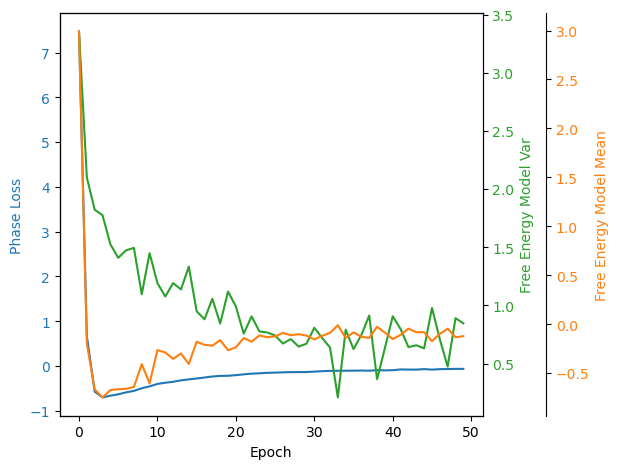

In [25]:
import matplotlib.pyplot as plt

#limit to first 10 epochs


epochs = list(metrics.keys())

epochs = epochs[:50]

loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]



fig, ax1 = plt.subplots()

# primary (blue) axis
ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
# ax1.set_ylim(0, 30)

# second axis (green) just to the right of the blue
ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax2.set_ylabel("Free Energy Model Var", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

# third axis (orange) further out
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
ax3.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax3.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax3.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [30]:
# assume:
#   model = ConditionalRBM(num_visible=…, num_hidden=…, …)
#   state = your restored TrainState with .params

import jax
import jax.numpy as jnp

# 1) prepare a dummy (or real) condition input of shape (B, N, 4)
#    e.g. B=1, N=16:
condition = jnp.ones((1, 8, 4), dtype=jnp.float32)

# 2) call only the conditioner
gamma_b, beta_b, gamma_c, beta_c = model.apply(
    {'params': state.params, 'rbm': rbm_vars},
    condition,
    method=ConditionalRBM.conditioner
)

print("γ_b:", gamma_b.shape, "β_b:", beta_b.shape)
print("γ_c:", gamma_c.shape, "β_c:", beta_c.shape)


ScopeParamShapeError: Initializer expected to generate shape (8, 64) but got shape (4, 64) instead for parameter "kernel" in "/Dense_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

In [36]:
# Instantiate the model with correct dimensions
model = ConditionalRBM(
    num_visible=8,
    num_hidden=16,     # <-- adjust if needed
    conditioner_width=64,
    k=1,
    T=1.0
)

# Create fake conditioning data (B=1, N=8, C=4)
cond_input = jnp.ones((1, 8, 4), dtype=jnp.float32)

# Flatten as expected by _condition_encoder: (B, N*C)
cond_flat = cond_input.reshape(1, -1)

# Initialize the model to get parameter shapes
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 8, 5)), jax.random.PRNGKey(42))["params"]

# Run just the conditioner
gamma, beta = model.apply(
    {"params": params},
    cond_flat,
    method=ConditionalRBM._condition_encoder
)

print("gamma shape:", gamma.shape)  # expected (1, num_hidden)
print("beta  shape:", beta.shape)
print("gamma:", gamma)
print("beta:", beta)


TypeError: JAX does not support string indexing; got idx=('key',)

In [38]:
# Define dimensions (adjust to your model config)
num_visible = 8
num_hidden = 16
batch_size = 1
key_dummy = jax.random.PRNGKey(0)
key_params = jax.random.PRNGKey(1)
l2_strength = 0.0

# Instantiate the model
model = ConditionalRBM(
    num_visible=num_visible,
    num_hidden=num_hidden,
    conditioner_width=64,
    k=100,
)

# Dummy inputs for full model init
batch_dummy = jnp.zeros((batch_size, num_visible, 3), dtype=jnp.float32)
aux_vars_dummy = {
    "key": key_dummy,
    "l2_strength": l2_strength,
}

# Initialize the model (gets you both 'params' and 'rbm')
variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)
params = variables["params"]

# Create a conditioning input: shape (1, 8, 4), filled with ones
cond_input = jnp.ones((1, num_visible, 4), dtype=jnp.float32)
cond_flat = cond_input.reshape(1, -1)  # → (1, 32)

# Call only the FiLM-style conditioner
gamma, beta = model.apply(
    {"params": params},
    cond_flat,
    method=ConditionalRBM._condition_encoder
)

# Optional: reconstruct c_mod
c0 = params["c"]  # this is your unmodulated hidden bias
c_mod = (1 + gamma) * c0 + beta

# Print results
print("gamma:", gamma.shape, gamma)
print("beta: ", beta.shape, beta)
print("c_mod:", c_mod.shape, c_mod)

AttributeError: type object 'ConditionalRBM' has no attribute '_condition_encoder'